# Thank You Calls Case

The given dataset from a travel company represents a subset of customers whose first booking was between 200 and 300 dollars. After their first hotel stay, a bot sent out thank you calls to certain customers, in the company's attempt to build a rapport with clients. The bot had only began sending out these calls in 2018 and 2019.

First, I will be importing the relevanat data analysis libraries: NumPy, Pandas, Matplotlib, and Seaborn. I also like iplot() from cufflinks when exploring the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)
cf.go_offline()

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

**Import the dataset as a Pandas DataFrame**

In [2]:
df = pd.read_csv('Thank YOU Call Data.csv')
df.head()

,USER_ID,MONTH,THANK_YOU_STATUS,LTR,BOOKINGS,GMV
0,10157,2018-09-01,thank_you_call,106.640369,6.0,4926.957
1,10263,2018-03-01,thank_you_call,388.322847,25.0,18481.635
2,10362,2018-01-01,thank_you_call,588.327102,15.0,7010.647
3,10382,2018-11-01,thank_you_call,6.402000,2.0,1144.032
4,10463,2019-01-01,no_call,51.815610,3.0,1271.090


In [3]:
# Check the info() of the DataFrame

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23759 entries, 0 to 23758
Data columns (total 6 columns):
USER_ID             23759 non-null int64
MONTH               23759 non-null object
THANK_YOU_STATUS    23759 non-null object
LTR                 23202 non-null float64
BOOKINGS            23202 non-null float64
GMV                 23202 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.1+ MB


In [4]:
df.describe()[['LTR','BOOKINGS','GMV']]

,LTR,BOOKINGS,GMV
count,23202.000000,23202.000000,23202.000000
mean,73.784503,1.920869,1120.685785
std,106.030714,15.036952,1831.220249
min,0.006633,1.000000,502.554000
25%,42.504000,1.000000,592.224750
50%,53.322500,1.000000,700.493500
75%,70.994000,2.000000,871.887500
max,5122.086550,2012.000000,73247.220000


Instinctively, I want to see how many customers were in each cohort:

**Cohort 1:** Customers who were given a thank you call

**Cohort 2:** Customers who were not given a thank you call

In [5]:
# Check how many customers were given a thank you call, and how many were not.

df['THANK_YOU_STATUS'].value_counts()

no_call           15472
thank_you_call     8287
Name: THANK_YOU_STATUS, dtype: int64

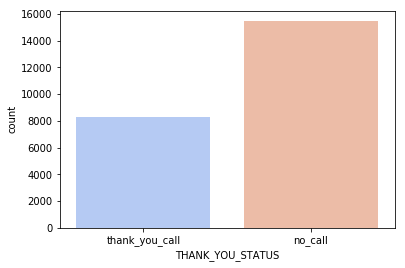

In [6]:
# Visualize the number of customers in each cohort

sns.countplot(data=df,x='THANK_YOU_STATUS',palette='coolwarm')

In [7]:
# Visualize the Month over Month change for the number of customers in each cohort
# To do so, I need to create a pivot table representing the number of customers whose first purchase was in each month

monthlyThankYouStatus = df.pivot_table(values='USER_ID',index='MONTH',columns='THANK_YOU_STATUS',aggfunc='count')
monthlyThankYouStatus.iplot()

## Data Cleaning

Looking at this information, we'll want to clean the data first and foremost, which can be done in the following ways:

First: Removing any months where there is no overlap between both cohorts, since we want to compare month over month behaviour for each cohort. This can be seen in June 2019. I will, however, first need to check if the average GMV per booking may skew results if that subset is excluded from the analysis. To do so, I need to calculate the average GMV per booking for each customer and see if that changes significantly in June 2019.

In [8]:
df['Average_GMV_per_Booking'] = df['GMV']/df['BOOKINGS']
df.head()

,USER_ID,MONTH,THANK_YOU_STATUS,LTR,BOOKINGS,GMV,Average_GMV_per_Booking
0,10157,2018-09-01,thank_you_call,106.640369,6.0,4926.957,821.159500
1,10263,2018-03-01,thank_you_call,388.322847,25.0,18481.635,739.265400
2,10362,2018-01-01,thank_you_call,588.327102,15.0,7010.647,467.376467
3,10382,2018-11-01,thank_you_call,6.402000,2.0,1144.032,572.016000
4,10463,2019-01-01,no_call,51.815610,3.0,1271.090,423.696667


In [9]:
monthlyAvgGMVperBooking = df.pivot_table(values='Average_GMV_per_Booking',index='MONTH',columns='THANK_YOU_STATUS',aggfunc='mean')
monthlyAvgGMVperBooking.iplot()

Looking at this data, we can see that there is no significant change for customers whose first order was in June 2019. Thus, we can remove this set of data. However, for data before August 2017, we see a significant spike in July 2017 data. We cannot remove this data without being certain that it won't skew the results of our analysis.

In [10]:
df = df[df['MONTH']<'2019-06-01']
monthlyThankYouStatus = df.pivot_table(values='USER_ID',index='MONTH',columns='THANK_YOU_STATUS',aggfunc='count')
monthlyThankYouStatus.iplot()

# That looks better

I will then take a look at the scatterplot of GMV versus Number of Bookings. This should help us identify any outliers.

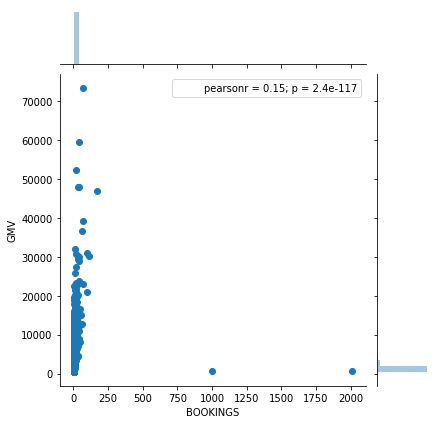

In [11]:
sns.jointplot(data=df,x='BOOKINGS',y='GMV')

We can see that there are two types of outliers that stick out:

1) Customers with a large amount of bookings, but low GMV

2) Customers with an average amount of bookings, but erroneously high GMV

In order to alleviate our dataset of these outliers, we can take the Z-Score of the Average GMV per Booking. The use of Z-Scores does not assume the data is normally distributed, as it is most definitely not. It assumes the data follows the Central Limit Theorem since there are over 23000 rows of data.

I like to identify outliers as data entries with a Z-Score larger than 3.

In [12]:
# I will create a new DataFrame, dfRemoved, in order to later compare results with the original dataset.
# Calculating Z-Scores
dfRemoved = df
dfRemoved['Z-Score_AverageGMV'] = abs((dfRemoved['Average_GMV_per_Booking'] - dfRemoved['Average_GMV_per_Booking'].mean())/dfRemoved['Average_GMV_per_Booking'].std(ddof=0))
dfRemoved.head()

,USER_ID,MONTH,THANK_YOU_STATUS,LTR,BOOKINGS,GMV,Average_GMV_per_Booking,Z-Score_AverageGMV
0,10157,2018-09-01,thank_you_call,106.640369,6.0,4926.957,821.159500,0.904472
1,10263,2018-03-01,thank_you_call,388.322847,25.0,18481.635,739.265400,0.485768
2,10362,2018-01-01,thank_you_call,588.327102,15.0,7010.647,467.376467,0.904333
3,10382,2018-11-01,thank_you_call,6.402000,2.0,1144.032,572.016000,0.369337
4,10463,2019-01-01,no_call,51.815610,3.0,1271.090,423.696667,1.127657


In [13]:
# Check how many of the outliers belong to each cohort

threshold = dfRemoved['Z-Score_AverageGMV'] > 3
dfRemoved[threshold]['THANK_YOU_STATUS'].value_counts()

# A total of 323 rows are being removed from the dataset

no_call           204
thank_you_call    119
Name: THANK_YOU_STATUS, dtype: int64

In [14]:
# Remove outliers from the dataset

dfRemoved = dfRemoved[dfRemoved['Z-Score_AverageGMV'] <= 3]
dfRemoved.head()

,USER_ID,MONTH,THANK_YOU_STATUS,LTR,BOOKINGS,GMV,Average_GMV_per_Booking,Z-Score_AverageGMV
0,10157,2018-09-01,thank_you_call,106.640369,6.0,4926.957,821.159500,0.904472
1,10263,2018-03-01,thank_you_call,388.322847,25.0,18481.635,739.265400,0.485768
2,10362,2018-01-01,thank_you_call,588.327102,15.0,7010.647,467.376467,0.904333
3,10382,2018-11-01,thank_you_call,6.402000,2.0,1144.032,572.016000,0.369337
4,10463,2019-01-01,no_call,51.815610,3.0,1271.090,423.696667,1.127657


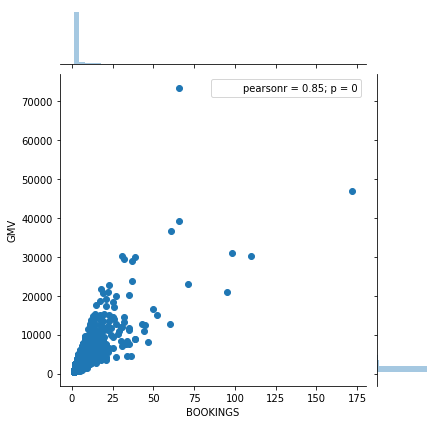

In [15]:
# Now we can take a look at the scatter plot once again

sns.jointplot(data=dfRemoved,x='BOOKINGS',y='GMV')

# That looks much better! 

In [16]:
monthlyAvgGMVperBookingRemoved = dfRemoved.pivot_table(values='Average_GMV_per_Booking',index='MONTH',columns='THANK_YOU_STATUS',aggfunc='mean')
monthlyAvgGMVperBookingRemoved.iplot()

# We can see that the June 2017 numbers were not removed, despite a large spike. 
# We will not be removing this data, as aforementioned, especially since it wasn't deemed to be an outlier.

# If more context was available on this data, we may have potentially been able to remove it.
# However, given the data available, we cannot do so.

When checking the info() of the DataFrame, we could see a discrepancy between the number of entries in the USER_ID column, and the LTR, BOOKINGS, and GMV columns. This indicates NaN data. I assume that this data belongs to customers that had booked a total of twice, but had cancelled the second booking before it was redeemed. In order to deal with these NaN values, I will first need to remove any outliers.

For this reason, I will be setting the values to the following:

- BOOKINGS: Set = 1, since these customers booked twice, but only redeemed one booking. I will assume that any cancelled bookings are not included within this dataset. i.e. Refunds have been accounted for.

- LTR and GMV: Set = the *mode* of average LTR/GMV among customers with 1 Booking within our dataset. We cannot assume that there are behaviour differences between customers who received a call and those that did not, since these customers technically only had one redeemed purchase. The call may influence their post-purchase behaviour, but definitely not their first purchase. Thus, I will not be differentiating between the different cohorts.

**Note: I prefered using the mode over other metrics in this case. I assumed that, as with most thing sold online, there would be a first time promo with a capped maximum price. Most consumers would probably attempt to use this promo for the most value for their money. I assumed that's what most consumers did, hence why the mode.**

**Note #2: I decided to use only customers with 1 Booking, rather than all customers within our dataset. I assumed the first booking of a customer would be most similar to the first bookings of other customers.**

In [17]:
# Mode GMV of Customers with only one booking

dfRemoved[dfRemoved['BOOKINGS']==1]['GMV'].mode()

0    525.096
dtype: float64

In [18]:
# Mode of LTR of Customers with only one booking

dfRemoved[dfRemoved['BOOKINGS']==1]['LTR'].mode()

# We can see that we get three modes here. We can take the mean of these modes for the desired outcome.

0    45.716
1    46.684
2    50.710
dtype: float64

In [19]:
dfRemoved[dfRemoved['BOOKINGS']==1]['LTR'].mode().mean()

47.70333333333334

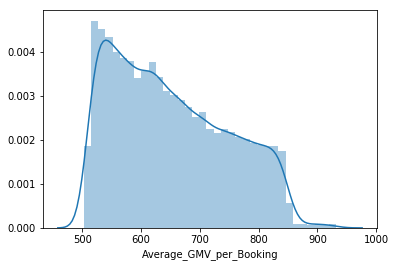

In [20]:
sns.distplot(dfRemoved[dfRemoved['BOOKINGS']==1]['Average_GMV_per_Booking'])

Now, let's deal with those NaN values

In [21]:
# Filling missing BOOKINGS data

dfRemoved['BOOKINGS'].fillna(value=1,inplace=True)

In [22]:
# Filling missing GMV data

dfRemoved['GMV'].fillna(dfRemoved[dfRemoved['BOOKINGS']==1]['GMV'].mode(),inplace=True)

In [23]:
# Filling missing LTR data

dfRemoved['LTR'].fillna(dfRemoved[dfRemoved['BOOKINGS']==1]['LTR'].mode().mean(),inplace=True)

In [24]:
# Let's check to see if there's any more data that's missing

dfRemoved.isna().sum()

# Nope! Our code worked perfectly fine.

USER_ID                    0
MONTH                      0
THANK_YOU_STATUS           0
LTR                        0
BOOKINGS                   0
GMV                        0
Average_GMV_per_Booking    0
Z-Score_AverageGMV         0
dtype: int64

In [25]:
# Fix up Average_GMV_per_Booking since we don't have any NaN values anymore

dfRemoved['Average_GMV_per_Booking'] = df['GMV']/df['BOOKINGS']
dfRemoved.drop('Z-Score_AverageGMV',axis=1,inplace=True) # we don't need this column anymore

dfRemoved.head()

,USER_ID,MONTH,THANK_YOU_STATUS,LTR,BOOKINGS,GMV,Average_GMV_per_Booking
0,10157,2018-09-01,thank_you_call,106.640369,6.0,4926.957,821.159500
1,10263,2018-03-01,thank_you_call,388.322847,25.0,18481.635,739.265400
2,10362,2018-01-01,thank_you_call,588.327102,15.0,7010.647,467.376467
3,10382,2018-11-01,thank_you_call,6.402000,2.0,1144.032,572.016000
4,10463,2019-01-01,no_call,51.815610,3.0,1271.090,423.696667


In [26]:
# Check to see if there are still NaNs in the Average_GMV_per_Booking column

dfRemoved['Average_GMV_per_Booking'].isna().sum()

0

# Data Analysis

Now that we have our data all cleaned up, we can start our analysis. Let's start off with taking a look at violin plots to compare between both cohorts

Text(0.5,0,'Thank You Call Status')

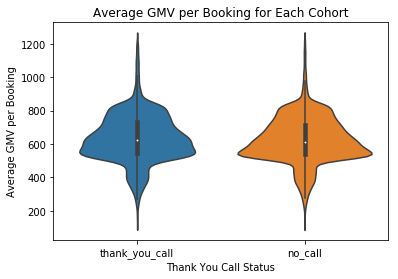

In [27]:
sns.violinplot(data=dfRemoved,x='THANK_YOU_STATUS',y='Average_GMV_per_Booking')
plt.title('Average GMV per Booking for Each Cohort')
plt.ylabel('Average GMV per Booking')
plt.xlabel('Thank You Call Status')

# We can see that the spread of average GMV per booking is relatively similar across both cohorts.

### Checking distributions

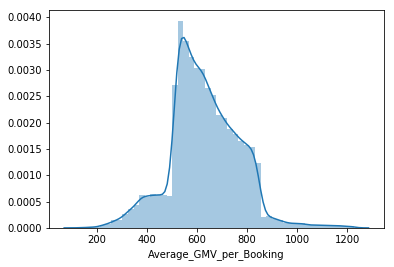

In [28]:
sns.distplot(dfRemoved['Average_GMV_per_Booking'])

### Splitting up the dataset into Two Cohorts

In [29]:
# Let's split up the dataset into two cohorts

callMade = dfRemoved[dfRemoved['THANK_YOU_STATUS']=='thank_you_call']
noCallMade = dfRemoved[dfRemoved['THANK_YOU_STATUS']=='no_call']

Let's take a look at the percentage of repeat customers for each cohort:

In [30]:
callMadeRepeat = pd.DataFrame({'Number of Purchases Greater Than or Equal To:':[2,3,4,5,6,7,8,9,10]})
repeatRates=[]
for i in callMadeRepeat['Number of Purchases Greater Than or Equal To:']:
    repeatRates.append(callMade[callMade['BOOKINGS']>=i]['USER_ID'].count()/callMade['USER_ID'].count())
callMadeRepeat['Repeat Rates'] = repeatRates
callMadeRepeat

,Number of Purchases Greater Than or Equal To:,Repeat Rates
0,2,0.276822
1,3,0.136260
2,4,0.083122
3,5,0.057439
4,6,0.042131
5,7,0.031756
6,8,0.025430
7,9,0.019231
8,10,0.015056


In [31]:
noCallMadeRepeat = pd.DataFrame({'Number of Purchases Greater Than or Equal To:':[2,3,4,5,6,7,8,9,10]})
repeatRates=[]
for i in noCallMadeRepeat['Number of Purchases Greater Than or Equal To:']:
    repeatRates.append(noCallMade[noCallMade['BOOKINGS']>=i]['USER_ID'].count()/noCallMade['USER_ID'].count())
noCallMadeRepeat['Repeat Rates'] = repeatRates
noCallMadeRepeat

,Number of Purchases Greater Than or Equal To:,Repeat Rates
0,2,0.260570
1,3,0.119815
2,4,0.072184
3,5,0.047899
4,6,0.034720
5,7,0.026224
6,8,0.020270
7,9,0.015922
8,10,0.013112


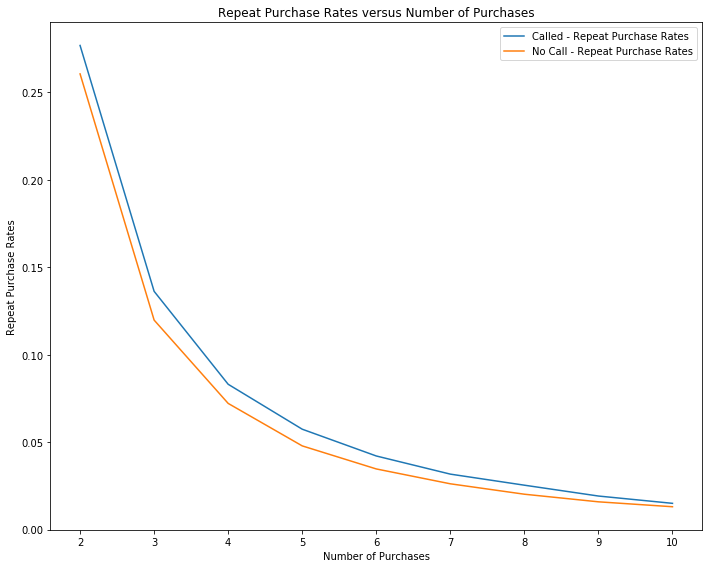

In [32]:
plt.figure(figsize=(10,8))
plt.plot(callMadeRepeat['Number of Purchases Greater Than or Equal To:'],callMadeRepeat['Repeat Rates'],noCallMadeRepeat['Number of Purchases Greater Than or Equal To:'],noCallMadeRepeat['Repeat Rates'])
plt.legend(['Called - Repeat Purchase Rates','No Call - Repeat Purchase Rates'])
plt.ylabel('Repeat Purchase Rates')
plt.xlabel('Number of Purchases')
plt.title('Repeat Purchase Rates versus Number of Purchases')
plt.tight_layout()

Foreseeably so, the repeat purchase rates eventually taper out to become somewhat equal, as the subset of customers who have purchased 10 or more bookings is much smaller. **This graph indicates that there is a higher propensity of repeat purchases among customers who did receive a thank you call, versus those who did not.** However, the main repeat purchase rate, which occurs when the number of purchases = 2, differs by 1.63%, as follows:

In [33]:
churn = (callMade[callMade['BOOKINGS']>=2]['USER_ID'].count()/callMade['USER_ID'].count()) - (noCallMade[noCallMade['BOOKINGS']>=2]['USER_ID'].count()/noCallMade['USER_ID'].count())
churn

0.016251886431667584

A churn difference of even 1.63% can have a large impact on expected lifetime GMV and thus lifetime LTR. To see the impact this may have, let's compile some Month over Month data:

In [34]:
# First, for the callMade DataFrame:
callPivot = callMade.pivot_table(values=['BOOKINGS','GMV','LTR'],aggfunc='sum',index='MONTH')
callPivot.head()

,BOOKINGS,GMV,LTR
MONTH,,,
2017-06-01,1.0,513.179,34.265000
2017-07-01,3.0,3416.235,228.008000
2017-08-01,2.0,1337.135,89.243000
2017-09-01,9.0,4093.447,205.123622
2017-10-01,52.0,31015.327,1322.888985


In [35]:
# Now let's create a column representing the number of customers per month

callCounts = callMade.pivot_table(values='USER_ID',aggfunc='count',index='MONTH')
callCounts.head()

,USER_ID
MONTH,
2017-06-01,1
2017-07-01,1
2017-08-01,2
2017-09-01,4
2017-10-01,29


In [36]:
callPivot = callPivot.join(callCounts,on='MONTH')
callPivot.rename(columns={'USER_ID':'Number of Customers'},inplace=True)
callPivot.head()

,BOOKINGS,GMV,LTR,Number of Customers
MONTH,,,,
2017-06-01,1.0,513.179,34.265000,1
2017-07-01,3.0,3416.235,228.008000,1
2017-08-01,2.0,1337.135,89.243000,2
2017-09-01,9.0,4093.447,205.123622,4
2017-10-01,52.0,31015.327,1322.888985,29


In [37]:
# Let's do that again for our noCallMade DataFrame:

noCallPivot = noCallMade.pivot_table(values=['BOOKINGS','GMV','LTR'],aggfunc='sum',index='MONTH')
noCallCounts = noCallMade.pivot_table(values='USER_ID',aggfunc='count',index='MONTH')
noCallPivot = noCallPivot.join(noCallCounts,on='MONTH')
noCallPivot.rename(columns={'USER_ID':'Number of Customers'},inplace=True)
noCallPivot.head()

,BOOKINGS,GMV,LTR,Number of Customers
MONTH,,,,
2017-06-01,5.0,5068.210,164.634052,1
2017-08-01,13.0,7374.498,410.500200,6
2017-09-01,7.0,4678.332,361.626342,2
2017-10-01,14.0,7410.300,409.347290,9
2017-11-01,80.0,48030.814,2314.692589,51


In [38]:
# Total number of customers left

callPivot['Number of Customers'].sum() + noCallPivot['Number of Customers'].sum()

22852

In [39]:
# Calculate average Bookings, GMV, and LTR per month, per customer

callPivot['avg_bookings'] = callPivot['BOOKINGS']/callPivot['Number of Customers']
callPivot['avg_GMV'] = callPivot['GMV']/callPivot['Number of Customers']
callPivot['avg_LTR'] = callPivot['LTR']/callPivot['Number of Customers']
callPivot['avg_GMV_per_booking'] = callPivot['GMV']/callPivot['BOOKINGS']
callPivot['avg_GMVpb_per_customer'] = callPivot['avg_GMV_per_booking']/callPivot['Number of Customers']

callPivot.head()

,BOOKINGS,GMV,LTR,Number of Customers,avg_bookings,avg_GMV,avg_LTR,avg_GMV_per_booking,avg_GMVpb_per_customer
MONTH,,,,,,,,,
2017-06-01,1.0,513.179,34.265000,1,1.000000,513.179000,34.265000,513.179000,513.179000
2017-07-01,3.0,3416.235,228.008000,1,3.000000,3416.235000,228.008000,1138.745000,1138.745000
2017-08-01,2.0,1337.135,89.243000,2,1.000000,668.567500,44.621500,668.567500,334.283750
2017-09-01,9.0,4093.447,205.123622,4,2.250000,1023.361750,51.280906,454.827444,113.706861
2017-10-01,52.0,31015.327,1322.888985,29,1.793103,1069.494034,45.616862,596.448596,20.567193


In [40]:
# Do the same for our noCallsMade Dataset

noCallPivot['avg_bookings'] = noCallPivot['BOOKINGS']/noCallPivot['Number of Customers']
noCallPivot['avg_GMV'] = noCallPivot['GMV']/noCallPivot['Number of Customers']
noCallPivot['avg_LTR'] = noCallPivot['LTR']/noCallPivot['Number of Customers']
noCallPivot['avg_GMV_per_booking'] = noCallPivot['GMV']/noCallPivot['BOOKINGS']
noCallPivot['avg_GMVpb_per_customer'] = noCallPivot['avg_GMV_per_booking']/noCallPivot['Number of Customers']

noCallPivot.head()

,BOOKINGS,GMV,LTR,Number of Customers,avg_bookings,avg_GMV,avg_LTR,avg_GMV_per_booking,avg_GMVpb_per_customer
MONTH,,,,,,,,,
2017-06-01,5.0,5068.210,164.634052,1,5.000000,5068.210000,164.634052,1013.642000,1013.642000
2017-08-01,13.0,7374.498,410.500200,6,2.166667,1229.083000,68.416700,567.269077,94.544846
2017-09-01,7.0,4678.332,361.626342,2,3.500000,2339.166000,180.813171,668.333143,334.166571
2017-10-01,14.0,7410.300,409.347290,9,1.555556,823.366667,45.483032,529.307143,58.811905
2017-11-01,80.0,48030.814,2314.692589,51,1.568627,941.780667,45.386129,600.385175,11.772258


Let's see the growth of customers in each cohort:

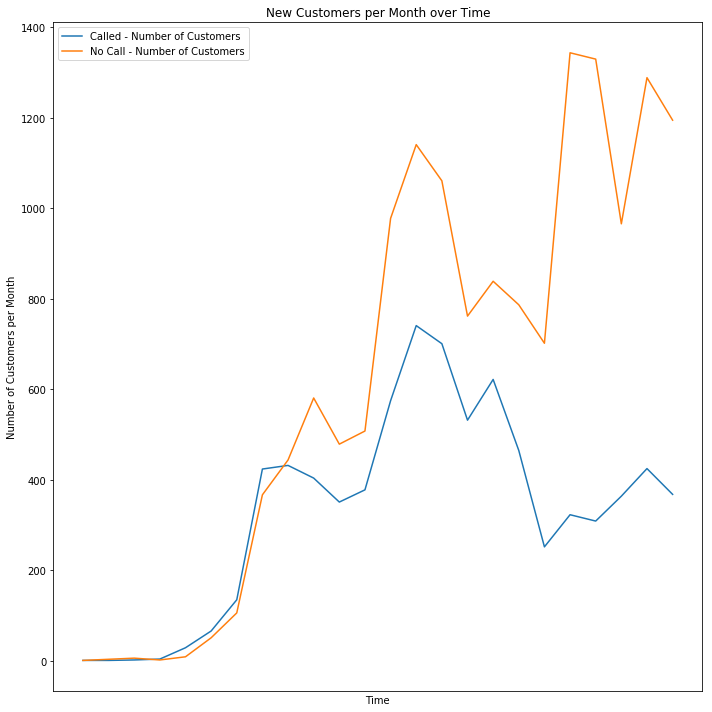

In [41]:
plt.figure(figsize=(10,10))
plt.plot(callPivot.index,callPivot['Number of Customers'],noCallPivot.index,noCallPivot['Number of Customers'])
plt.legend(['Called - Number of Customers','No Call - Number of Customers'])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.xlabel('Time')
plt.ylabel('Number of Customers per Month')
plt.title('New Customers per Month over Time')
plt.tight_layout()

Now, let's take a look at overall customer growth, using running totals for each month:

In [42]:
dfPivot = df.pivot_table(values='USER_ID',aggfunc='count',index='MONTH')

In [71]:
dfPivot['Running Total'] = np.cumsum(dfPivot['USER_ID'])
dfPivot.head()

,USER_ID,Running Total
MONTH,,
2017-05-01,2,2
2017-06-01,2,4
2017-07-01,1,5
2017-08-01,10,15
2017-09-01,10,25


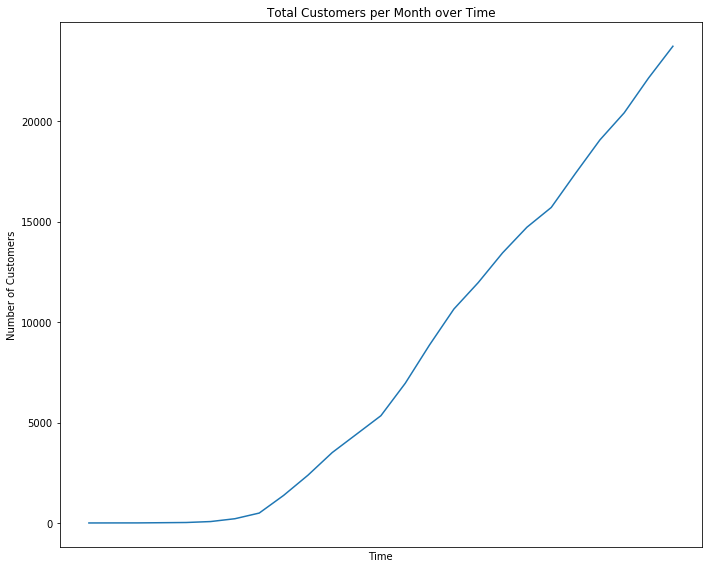

In [44]:
plt.figure(figsize=(10,8))
plt.plot(dfPivot.index,dfPivot['Running Total'])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.xlabel('Time')
plt.ylabel('Number of Customers')
plt.title('Total Customers per Month over Time')
plt.tight_layout()

In [72]:
# Let's take a look at overall customer growth within this subset over the two-year span:

dfPivot['Running Total'][-1]/dfPivot['Running Total'][0] - 1

# That's over 1,186,500% growth over 2 years!

11865.0

We can see that the customer base has been growing rapidly. However, most new customers aren't receiving any thank you calls. As we had seen before, the churn rate could potentially impactful with a growing customer base. Let's see the difference this could make by looking at some numbers:

In [46]:
# Total Number of Customers with Repeat Purchases:

totalCustomers = dfRemoved[dfRemoved['BOOKINGS']>=2]['USER_ID'].count()
totalCustomers

6083

In [47]:
# Total GMV Generated from Repeat Purchases (per customer):

totalGMV = dfRemoved[dfRemoved['BOOKINGS']>=2]['GMV'].sum()
GMVperCustomer = totalGMV/totalCustomers

In [48]:
# Total LTR Generated from Repeat Purchases (per customer):

totalLTR = dfRemoved[dfRemoved['BOOKINGS']>=2]['LTR'].sum()
LTRperCustomer = totalLTR/totalCustomers

In [49]:
# The churn rate indicates a difference in per Customer GMV of:

GMVperCustomer*churn

33.62438747857674

In [50]:
# And an LTR per customer of:

LTRperCustomer*churn

2.0346567145455783

These values are only evaluated over the basis of 24 months of data after the data cleaning process. Moreover, let's assume the company has a customer base of 1 million customers, and that all customer behaviour is similar to that in this dataset. Let's assume 65% of these customers did not receive a call.

In [73]:
1000000*0.65*LTRperCustomer*churn

1322526.864454626

In [74]:
1000000*0.65*GMVperCustomer*churn

21855851.861074883

We can see that this could impact the numbers greatly. By over 1.3 million CAD in LTR and around 22 million CAD in GMV over the course of 24 months.

Now let's see if the average bookings per customer for each cohort differs from the other.

In [53]:
callMadeAvgBookings = callMade['BOOKINGS'].mean()
callMadeAvgBookings

1.805161943319838

In [54]:
noCallMadeAvgBookings = noCallMade['BOOKINGS'].mean()
noCallMadeAvgBookings

1.723976451699224

In [63]:
purchaseDifference = callMadeAvgBookings/noCallMadeAvgBookings - 1

We can now see that there is a 4.71% difference between the two means. This indicates that, on average, when a customer is given a thank you call, they will purchase 4.71% more bookings. Let's see if this figure is statistically significant:

In [56]:
# Conduct a statistical test of significance between the two means.

from scipy import stats

t2, p2 = stats.ttest_ind(callMade['BOOKINGS'],noCallMade['BOOKINGS'])

print("t = " + str(t2))
print("p = " + str(p2))

t = 1.9950885111967962
p = 0.04604508210230207


Since p < 0.05, at the 5 per cent level of significance, we can see that there is indeed a statistical difference between the two means! Thus, we see that **average bookings per customer are 4.71% higher when customers receive a thank you call**. This could have potentially increased the total bookings of the cohort that did not receive calls by around 53,000 bookings, as follows:

In [64]:
noCallMadeAvgBookings = noCallMade['BOOKINGS'].mean()

# assume 65% of the customers received no call

1000000*0.65*noCallMadeAvgBookings*purchaseDifference 

52770.569553399066

In addition, let's look at the average bookings per customer per month:

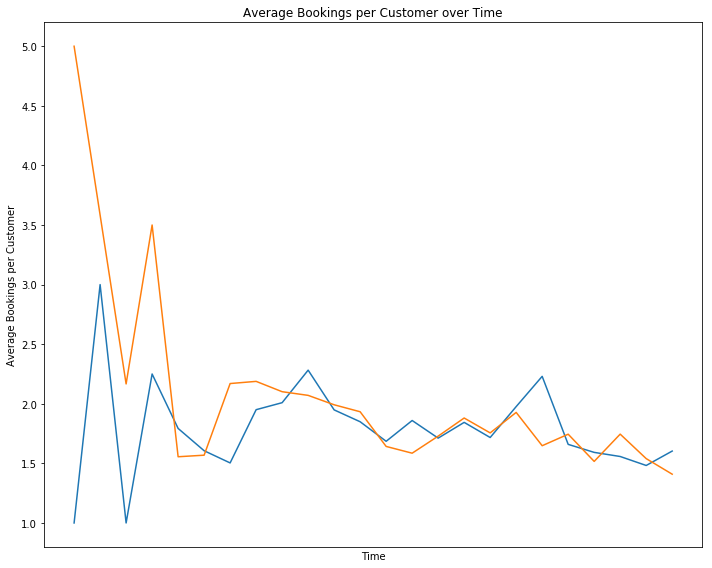

In [60]:
plt.figure(figsize=(10,8))
plt.plot(callPivot.index,callPivot['avg_bookings'],noCallPivot.index,noCallPivot['avg_bookings'])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.xlabel('Time')
plt.ylabel('Average Bookings per Customer')
plt.title('Average Bookings per Customer over Time')
plt.tight_layout()

Nothing special there, and understandably so. Some of these customers have been around for 2 years, while others, only for a month! 

Repeat purchase rates are the way to go for evaluating this problem!

Save the cleaned up data

In [ ]:
#dfRemoved.to_csv('dfRemoved.csv')